In [1]:
%matplotlib inline

import os
import sys
import time

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfd = tf.contrib.distributions
layers = tf.keras.layers

tf.enable_eager_execution()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Found GPU at: /device:GPU:0
TensorFlow version: 1.12.0
Eager execution: True


In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [3]:
X = x_train

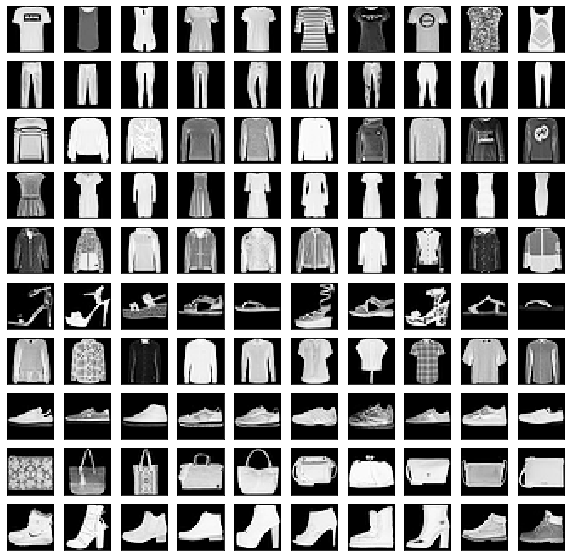

In [4]:
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(10,10), nrows=rows, ncols=cols, sharex=True, sharey=True)

for i, ax_row in enumerate(axes):
  imgs = X[np.where(y_train == i)[0][:10]]
  for j, ax in enumerate(ax_row):
    _ = ax.imshow(imgs[j], cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [5]:
class MaskedConv2D(layers.Conv2D):
  def __init__(self, mask_type='A', *args, **kwargs):
    super(MaskedConv2D, self).__init__(*args, **kwargs)
    self.mask_type = mask_type

  def call(self, inputs):
    kernel_h, kernel_w = self.kernel_size
    center_h = kernel_h // 2
    center_w = kernel_w // 2
    
    weights = self.kernel
    mask = np.ones_like(weights.numpy(), dtype='float32')
    #print(weights.shape, mask.shape)
    
    # kernel shape: [kernel_h, kernel_w, size_in, size_out]
    mask[center_h+1:, :, :, :] = 0.0
    mask[center_h:, center_w+1:, :, :] = 0.0
    
    if self.mask_type == 'A':
      mask[center_h,center_w,:,:] = 0.0

    weights = tf.math.multiply(weights, mask)
    
    outputs = self._convolution_op(inputs, weights)

    if self.data_format == 'channels_first':
        outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
    else:
        outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')

    if self.activation is not None:
        return self.activation(outputs)
    return outputs
  
layer = MaskedConv2D(
    filters=64, kernel_size=5, mask_type='A', padding='SAME', activation=None)
# print(layer(tf.zeros([1,28,28,1])))
# print(layer.variables)

In [6]:
class ResnetIdentityBlock(tf.keras.Model):
  def __init__(self, kernel_size, filters):
    super(ResnetIdentityBlock, self).__init__(name='')
    filters1, filters2, filters3 = filters

    self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
    self.conv2b = MaskedConv2D(
        filters=filters2, kernel_size=kernel_size, padding='same')
    self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))

  def call(self, input_tensor):
    x = self.conv2a(input_tensor)
    x = tf.nn.relu(x)

    x = self.conv2b(x)
    x = tf.nn.relu(x)

    x = self.conv2c(x)

    x += input_tensor
    return tf.nn.relu(x)

feature_map_size_RES = 128
filters = [feature_map_size_RES, feature_map_size_RES, 2*feature_map_size_RES]    
block = ResnetIdentityBlock(3, filters)
# print(block(tf.zeros([1, 2, 3, 2*feature_map_size_RES])))
# print([x.name for x in block.variables])


In [7]:
class PixelCNN(tf.keras.Model):
  def __init__(self, num_layers=15, h_residual=128, h_maskB=32):
    super(PixelCNN, self).__init__(name='')
    self.num_layers = num_layers
    
    # mask A, 7*7
    self.first_layer = MaskedConv2D(
        filters=2*h_residual, kernel_size=7, mask_type='A', padding='SAME', activation=None)
    
    # mask B, 3*3, num_layers=15, h_residual
    filters = [h_residual, h_residual, 2*h_residual]    
    self.res_block = ResnetIdentityBlock(3, filters)
    
    # mask B, 1*1, num_layers=2, h_maskB, Relu
    self.conv_1by1_a = tf.keras.layers.Conv2D(h_maskB, (1, 1))
    self.conv_1by1_b = tf.keras.layers.Conv2D(256, (1, 1))
    
  def call(self, input_tensor):
    x = self.first_layer(input_tensor)
    
    for i in range(self.num_layers):
      x = self.res_block(x)
      
    x = self.conv_1by1_a(x)
    x = tf.nn.relu(x)
    x = self.conv_1by1_b(x)
    
    return x

pixel_cnn = PixelCNN(num_layers=15, h_residual=512, h_maskB=512)
output_img = pixel_cnn(tf.zeros([1,28,28,1]))
#print(pixel_cnn(tf.zeros([1,28,28,1])))
#print(pixel_cnn.variables)

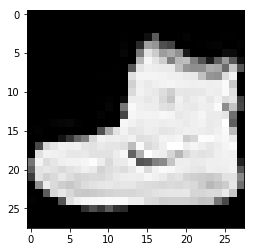

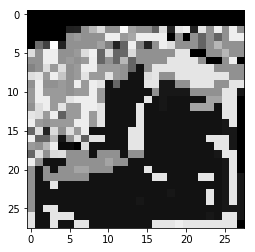

In [8]:
sample = X[0]
sample_in = sample[np.newaxis, :, :, np.newaxis]

output_img = pixel_cnn(tf.constant(sample_in))
output_img = np.argmax(output_img, axis=3)
plt.imshow(np.squeeze(sample), cmap='Greys_r'); plt.show()
plt.imshow(np.squeeze(output_img), cmap='Greys_r'); plt.show()

In [9]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=np.squeeze(y), logits=y_)

sample_img = X[0:3]
sample_img = sample_img[:, :, :, np.newaxis]
l = loss(pixel_cnn, sample_img, sample_img.astype('int'))
print("Loss test: {}".format(l))

Loss test: 55.087066650390625


In [10]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [11]:
global_step = tf.Variable(0)

loss_value, grads = grad(pixel_cnn, sample_img, sample_img.astype('int'))

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))


Step: 0, Initial Loss: 55.087066650390625


In [12]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(60000).batch(batch_size)

In [13]:
def generate(num_samples):
    samples = np.zeros((num_samples, 28, 28, 1), dtype='float32')

    for i in range(28):
      for j in range(28):
        for k in range(1):
          next_sample_logit = pixel_cnn(samples)
          next_sample_prob = tf.nn.softmax(next_sample_logit)
          dist = tf.distributions.Categorical(probs=next_sample_prob)
          next_sample = dist.sample()
          next_sample = next_sample[:, :, :, np.newaxis]
          samples[:, i, j, k] = next_sample[:, i, j, k]

    return samples

def generate_with_samples(samples_in):
    samples_out = pixel_cnn(samples_in)
    return samples_out

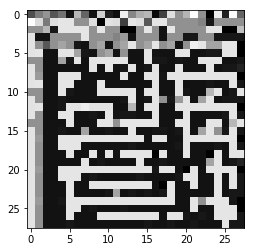

In [14]:
output_img = generate(1)
plt.imshow(np.squeeze(output_img), cmap='Greys_r'); plt.show()

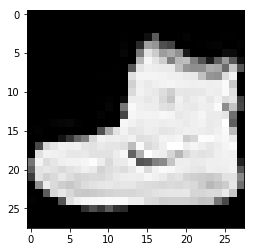

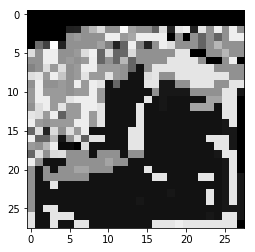

In [15]:
sample = X[0]
sample_in = sample[np.newaxis, :, :, np.newaxis]
output_img = generate_with_samples(sample_in)

output_img = np.argmax(output_img, axis=3)
plt.imshow(np.squeeze(sample), cmap='Greys_r'); plt.show()
plt.imshow(np.squeeze(output_img), cmap='Greys_r'); plt.show()

In [16]:
# ref: https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=(10,1))
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        #a.set_title(title)
        a.set_axis_off()
    #fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

Epoch 000 Iter 000: Loss: 58.8555068970


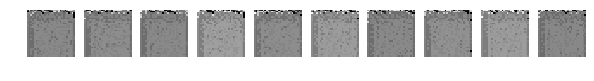

Epoch 000 Iter 500: Loss: 3.3589843661


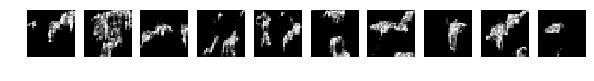

Epoch 000 Iter 1000: Loss: 2.9342330886


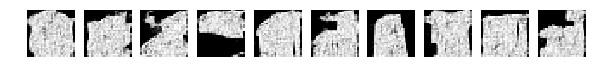

Epoch 000 Iter 1500: Loss: 2.7560083018


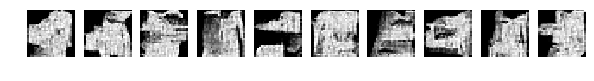

Epoch 000: Loss: 2.6732379363


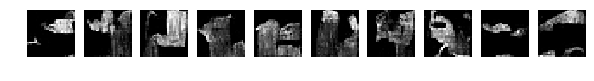

Epoch 001 Iter 000: Loss: 2.2383120060
Epoch 001 Iter 500: Loss: 2.3008623209
Epoch 001 Iter 1000: Loss: 2.2851543881
Epoch 001 Iter 1500: Loss: 2.2708106611
Epoch 001: Loss: 2.2604630219


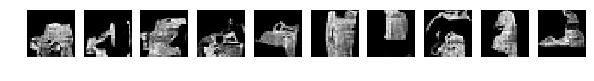

Epoch 002 Iter 000: Loss: 2.5346434116
Epoch 002 Iter 500: Loss: 2.2081578918
Epoch 002 Iter 1000: Loss: 2.2012694400
Epoch 002 Iter 1500: Loss: 2.1932590745
Epoch 002: Loss: 2.1884727914


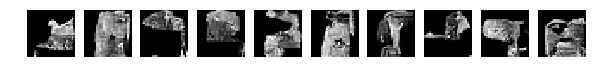

Epoch 003 Iter 000: Loss: 2.1124336720
Epoch 003 Iter 500: Loss: 2.1574775302
Epoch 003 Iter 1000: Loss: 2.1567463578
Epoch 003 Iter 1500: Loss: 2.1550296443
Epoch 003: Loss: 2.1502689996


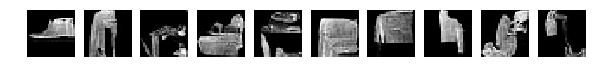

Epoch 004 Iter 000: Loss: 2.1217558384
Epoch 004 Iter 500: Loss: 2.1276669293
Epoch 004 Iter 1000: Loss: 2.1271085869
Epoch 004 Iter 1500: Loss: 2.1245203328
Epoch 004: Loss: 2.1229794403


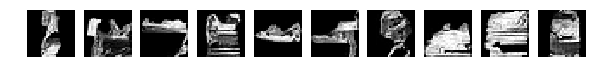

Epoch 005 Iter 000: Loss: 2.0782370567
Epoch 005 Iter 500: Loss: 2.1092381301
Epoch 005 Iter 1000: Loss: 2.1069151413
Epoch 005 Iter 1500: Loss: 2.1068849517
Epoch 005: Loss: 2.1051821222


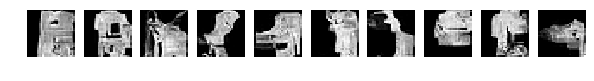

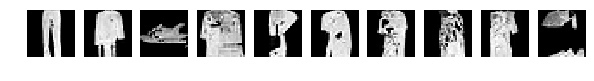

Epoch 046 Iter 000: Loss: 1.9617136717
Epoch 046 Iter 500: Loss: 1.9437489329
Epoch 046 Iter 1000: Loss: 1.9495275559
Epoch 046 Iter 1500: Loss: 1.9483117612
Epoch 046: Loss: 1.9481967185


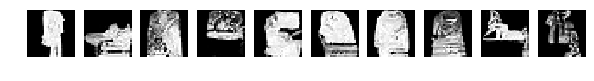

Epoch 047 Iter 000: Loss: 1.9926166534
Epoch 047 Iter 500: Loss: 1.9469343471
Epoch 047 Iter 1000: Loss: 1.9494128595
Epoch 047 Iter 1500: Loss: 1.9475235823
Epoch 047: Loss: 1.9466509442


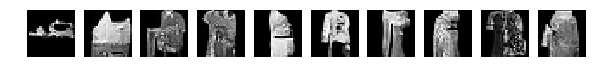

Epoch 048 Iter 000: Loss: 2.0646114349
Epoch 048 Iter 500: Loss: 1.9449631444
Epoch 048 Iter 1000: Loss: 1.9464807426
Epoch 048 Iter 1500: Loss: 1.9460971741
Epoch 048: Loss: 1.9460522572


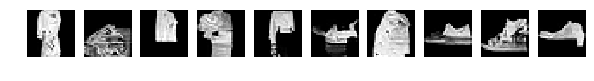

Epoch 049 Iter 000: Loss: 2.0978224277
Epoch 049 Iter 500: Loss: 1.9457130608
Epoch 049 Iter 1000: Loss: 1.9468096906
Epoch 049 Iter 1500: Loss: 1.9452561334
Epoch 049: Loss: 1.9450310660


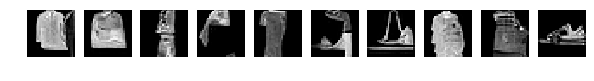

In [17]:
# keep results for plotting
train_loss_results = []

num_epochs = 50
learning_rate=tf.train.exponential_decay(
            learning_rate=0.0001,
            decay_steps=1000,
            global_step=tf.train.get_or_create_global_step(),
            decay_rate=0.9)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)

for epoch in range(num_epochs):
  epoch_loss_avg = tf.contrib.eager.metrics.Mean()

  # Training loop 
  for i, x in enumerate(dataset):
    # Optimize the model
    batch_x = x[:, :, :, np.newaxis]
    batch_y = batch_x.numpy().astype('int')
    loss_value, grads = grad(pixel_cnn, batch_x, batch_y)
    optimizer.apply_gradients(zip(grads, pixel_cnn.variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    
    if i % 500 == 0:
      print("Epoch {:03d} Iter {:03d}: Loss: {:.10f}".format(epoch, i, epoch_loss_avg.result()))
    
      if epoch == 0:
        result = generate(10)
        show_images(np.squeeze(result))

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  print("Epoch {:03d}: Loss: {:.10f}".format(epoch, epoch_loss_avg.result()))

  result = generate(10)
  show_images(np.squeeze(result))

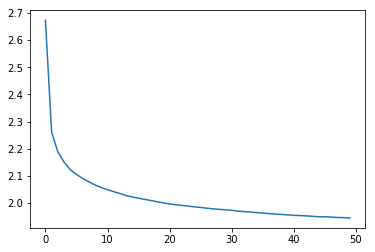

In [18]:
plt.plot(train_loss_results)

In [19]:
sample_in = X[0]
sample_in = sample_in[np.newaxis, :, :, np.newaxis]
sample_out = generate_with_samples(sample_in)

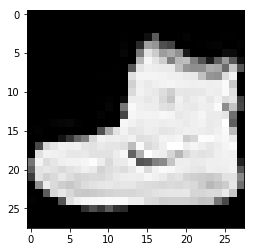

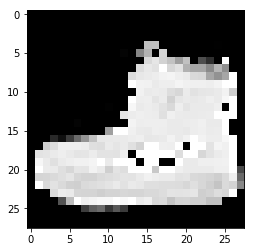

In [20]:
sample_out_prob = tf.nn.softmax(sample_out)
sample_out_color = np.argmax(sample_out_prob, axis=3)
plt.imshow(np.squeeze(sample_in), cmap='Greys_r'); plt.show()
plt.imshow(np.squeeze(sample_out_color), cmap='Greys_r'); plt.show()

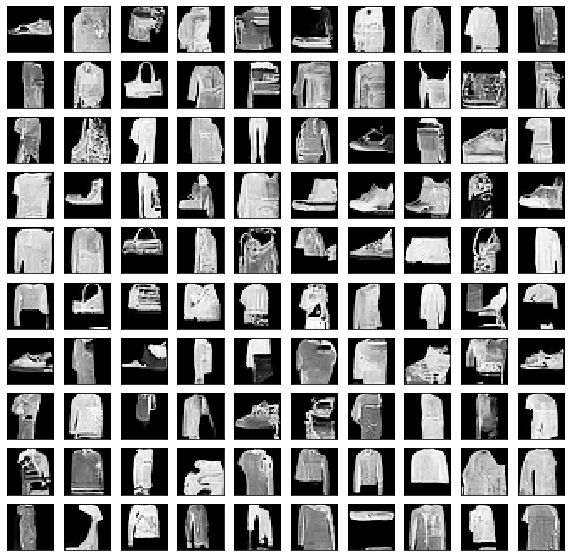

In [21]:
result = generate(100)

rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(10,10), nrows=rows, ncols=cols, sharex=True, sharey=True)

for i, ax_row in enumerate(axes):
  for j, ax in enumerate(ax_row):
    _ = ax.imshow(np.squeeze(result[i*10+j]), cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [22]:
print('Done')

Done
